In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [3]:
data = input_data.read_data_sets("./data/mnist", one_hot = True)

Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/fashion/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
print("Training set images shape: {}".format(data.train.images.shape))
print("Training set labels shape: {}".format(data.train.labels.shape))
print("Test set images shape: {}".format(data.test.images.shape))
print("Test set labels shape: {}".format(data.test.labels.shape))

Training set images shape: (55000, 784)
Training set labels shape: (55000, 10)
Test set images shape: (10000, 784)
Test set labels shape: (10000, 10)


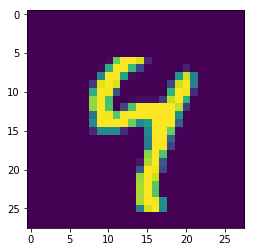

In [11]:
img = np.reshape(data.train.images[2], (28,28))
plt.imshow(img)

In [38]:
print("Max Value: {}\nMin Value: {}".format(np.max(img), np.min(img)))

Max Value: 1.0
Min Value: 0.0


In [39]:
train_X = data.train.images.reshape(-1, 28, 28, 1)
test_X = data.test.images.reshape(-1, 28, 28, 1)
print("Train Shape: {}\nTest Shape: {}".format(train_X.shape, test_X.shape))

Train Shape: (55000, 28, 28, 1)
Test Shape: (10000, 28, 28, 1)


In [40]:
train_y = data.train.labels
test_y = data.test.labels

In [41]:
epochs = 10
learning_rate = 0.001
batch_size = 128

In [42]:
n_input = 28
n_classes = 10

In [43]:
x = tf.placeholder("float", [None, 28, 28, 1])
y = tf.placeholder("float", [None, n_classes])

In [44]:
def conv2d(x, W, b, stride = 1):
    x = tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = "SAME")
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k = 2):
    return tf.nn.max_pool(x, ksize = [1, k , k , 1], strides = [1, k , k, 1], padding = "SAME")

In [ ]:
weights = {
    'wc1' : tf.get_variable('W0', shape = (3, 3, 1, 32), initializer = tf.contrib.layers.xavier_initializer()),
    'wc2' : tf.get_variable('W1', shape = (3, 3, 32, 64), initializer = tf.contrib.layers.xavier_initializer()),
    'wc3' : tf.get_variable('W2', shape = (3, 3, 64, 128), initializer = tf.contrib.layers.xavier_initializer()),
    'wd1' : tf.get_variable('W3', shape = (4 * 4 * 128, 128), initializer = tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('W4', shape = (128, n_classes), initializer = tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1': tf.get_variable('B0', shape = (32), initializer = tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape = (64), initializer = tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape = (128), initializer = tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape = (128), initializer = tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape = (10), initializer = tf.contrib.layers.xavier_initializer()),
}

In [46]:
def conv_net(x, weights, biases):
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k = 2)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k = 2)
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = maxpool2d(conv3, k = 2)
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [47]:
pred = conv_net(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [48]:
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [49]:
init = tf.global_variables_initializer()

In [50]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(epochs):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")


        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.017856, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.97040
Iter 1, Loss= 0.007680, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98530
Iter 2, Loss= 0.002753, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98720
Iter 3, Loss= 0.001578, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98840
Iter 4, Loss= 0.001109, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98910
Iter 5, Loss= 0.000578, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99010
Iter 6, Loss= 0.000345, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99040
Iter 7, Loss= 0.000277, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98930
Iter 8, Loss= 0.000386, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.99140
Iter 9, Loss= 0.000063, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98830


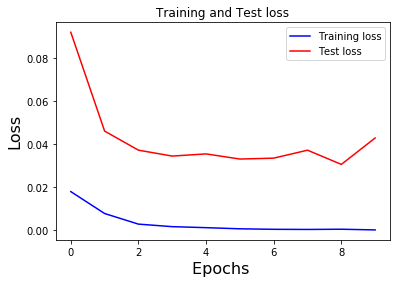

In [51]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

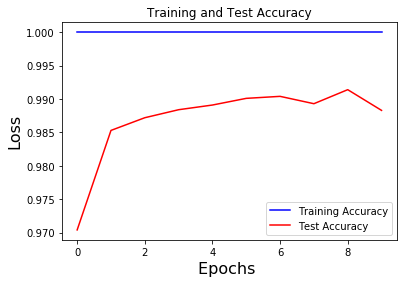

In [52]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()